In [278]:
pip install transformers

Note: you may need to restart the kernel to use updated packages.


In [279]:
pip install torch


In [280]:
pip install nltk

In [281]:
pip install pandas

In [282]:
pip install matplotlib

Note: you may need to restart the kernel to use updated packages.


In [283]:
pip install rouge-score

Note: you may need to restart the kernel to use updated packages.


In [284]:
pip install numpy

Note: you may need to restart the kernel to use updated packages.


In [285]:
pip install pyarrow

In [286]:
import torch
import warnings
from transformers import AutoTokenizer, AutoModelForCausalLM
from nltk.translate.bleu_score import corpus_bleu, SmoothingFunction
from rouge_score import rouge_scorer
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [287]:
warnings.filterwarnings("ignore")

In [288]:
models = [
    "microsoft/DialoGPT-medium",
    "Pi3141/DialoGPT-medium-elon-2",
    "0xDEADBEA7/DialoGPT-small-rick",
    "satvikag/chatbot",
    "microsoft/DialoGPT-large"
]

In [289]:
prompts = [
    "What is your favorite book and why?",
    "Share a memorable travel experience.",
    "Any tips for improving productivity?",
    "If you could have dinner with any historical figure, who would it be?",
    "Can you recommend a good movie to watch?"
]

responses = [
    "My favorite book is 'The Great Gatsby' because of its captivating storyline and rich characters.",
    "During a trip to Italy, I had the most amazing pasta in a small local restaurant.",
    "To improve productivity, try breaking tasks into smaller, manageable steps and prioritize them.",
    "If I could have dinner with any historical figure, it would be Albert Einstein for his brilliant mind.",
    "I recommend watching the movie 'Inception' for its mind-bending plot and stunning visuals."
]


In [290]:
results_dict = {}

In [291]:
def calculate_bleu(references, candidates):
    smoothie = SmoothingFunction().method4
    return corpus_bleu(references, candidates, smoothing_function=smoothie)

In [292]:
from nltk.translate.bleu_score import corpus_bleu, SmoothingFunction

def calculate_bleu(references, candidates):
    smoothie = SmoothingFunction().method4
    references_tokenized = [tuple(ref.split()) for sublist in references for ref in sublist]
    candidates_tokenized = [tuple(cand.split()) for sublist in candidates for cand in sublist]
    return corpus_bleu([references_tokenized], [candidates_tokenized], smoothing_function=smoothie)



In [293]:
def calculate_rouge(references, candidate):
    scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
    scores = scorer.score(references, candidate)
    rouge1 = scores['rouge1'].fmeasure
    rouge2 = scores['rouge2'].fmeasure
    rougeL = scores['rougeL'].fmeasure
    return rouge1, rouge2, rougeL

In [294]:
for model_name in models:
    bleu_scores = []
    rouge1_scores = []
    rouge2_scores = []
    rougeL_scores = []
    response_lengths = []

    tokenizer = AutoTokenizer.from_pretrained(model_name)
    tokenizer.pad_token = tokenizer.eos_token
    model = AutoModelForCausalLM.from_pretrained(model_name)

    input_ids = tokenizer(prompts, return_tensors="pt", padding=True, truncation=True)["input_ids"]

    with torch.no_grad():
        output = model.generate(input_ids=input_ids, max_length=100)

    generated_responses = [tokenizer.decode(ids, skip_special_tokens=True) for ids in output]

    for response, generated_response in zip(responses, generated_responses):
        # Calculate BLEU score
        bleu_score = calculate_bleu([[response]], [[generated_response]])
        bleu_scores.append(bleu_score)

        # Calculate ROUGE scores
        rouge1, rouge2, rougeL = calculate_rouge(response, generated_response)
        rouge1_scores.append(rouge1)
        rouge2_scores.append(rouge2)
        rougeL_scores.append(rougeL)

        # Calculate response length
        response_lengths.append(len(generated_response.split()))

    # Calculate average scores
    avg_bleu_score = sum(bleu_scores) / len(bleu_scores)
    avg_rouge1_score = sum(rouge1_scores) / len(rouge1_scores)
    avg_rouge2_score = sum(rouge2_scores) / len(rouge2_scores)
    avg_rougeL_score = sum(rougeL_scores) / len(rougeL_scores)
    avg_response_length = sum(response_lengths) / len(response_lengths)

    # Store results
    results_dict[model_name] = {
        "BLEU": avg_bleu_score,
        "ROUGE-1": avg_rouge1_score,
        "ROUGE-2": avg_rouge2_score,
        "ROUGE-L": avg_rougeL_score,
        "Response Length": avg_response_length
    }



The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` t

In [295]:
results_df = pd.DataFrame(results_dict).T

In [296]:
results_df.to_csv('results.csv')
data = pd.read_csv('results.csv')

In [297]:
import numpy as np
data=pd.read_csv("results.csv")
weights = '1,1,1,1,1'
impacts = '+,+,+,+,-'
import sys
# HANDLING EXCEPTIONS
if data.shape[1] < 3:
    raise ValueError("Input file does not contain three or more columns.")
if not data.iloc[:, 1:].apply(np.isreal).all().all():
    raise ValueError("Columns from 2nd to last do not contain numeric values only.")
if len(weights.split(',')) != len(impacts.split(',')) != data.shape[1] - 1:
    raise ValueError("Number of weights, impacts, and columns must be the same.")
if not all(impact in ['+', '-'] for impact in impacts.split(',')):
    raise ValueError("Impacts must be either +ve or -ve.")
    
# TOPSIS PROGRAM
def vector_normalization(data):
    normalized_data = data.iloc[:, 1:].apply(
        lambda x: x / np.sqrt(np.sum(x**2)), axis=0)
    return normalized_data

normalized_data = vector_normalization(data)
weighted_normalized_matrix = normalized_data * list(map(float, weights.split(',')))
ideal_best = weighted_normalized_matrix.max(
) if impacts[0] == '+' else weighted_normalized_matrix.min()
ideal_worst = weighted_normalized_matrix.min(
) if impacts[0] == '+' else weighted_normalized_matrix.max()
performance_score = np.sqrt(np.sum((weighted_normalized_matrix - ideal_worst)**2, axis=1)) / (
    np.sqrt(np.sum((weighted_normalized_matrix - ideal_best)**2, axis=1)) +
    np.sqrt(np.sum((weighted_normalized_matrix - ideal_worst)**2, axis=1))
)

result_topsis = data.copy()
result_topsis['Topsis Score'] =  performance_score
result_topsis['Rank'] = result_topsis['Topsis Score'].rank(ascending=False)

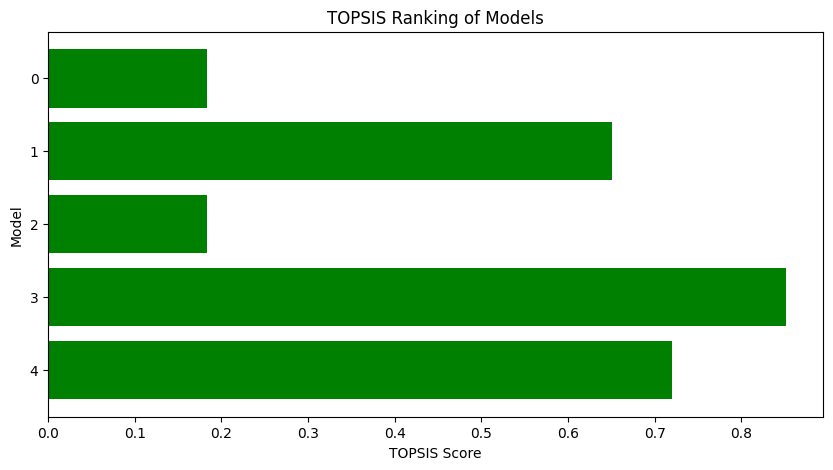

In [298]:
plt.figure(figsize=(10, 5))
plt.barh(topsis_results_sorted.index, topsis_results_sorted['Topsis Score'], color='green')
plt.xlabel('TOPSIS Score')
plt.ylabel('Model')
plt.title('TOPSIS Ranking of Models')
plt.gca().invert_yaxis() 

TOPSIS results saved to topsis_results.csv


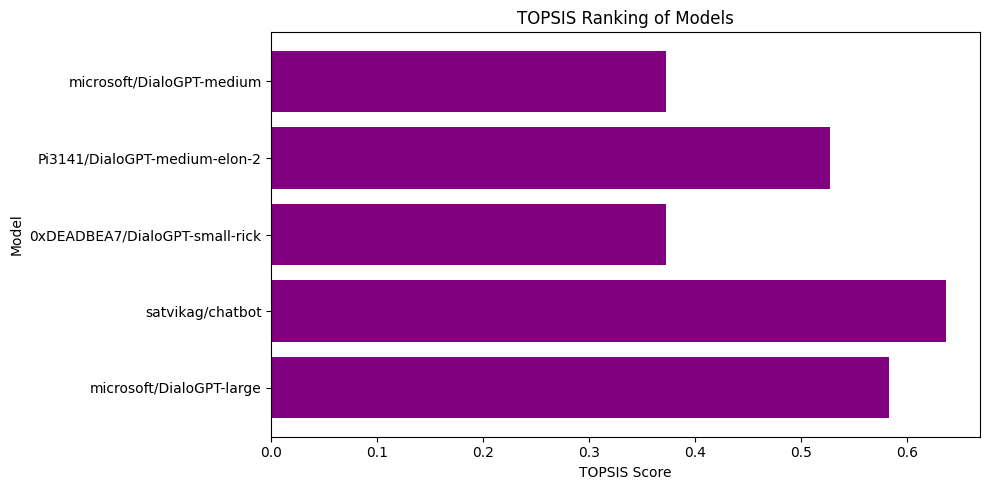

TOPSIS Bar Graph saved to topsis_BarGraph.png


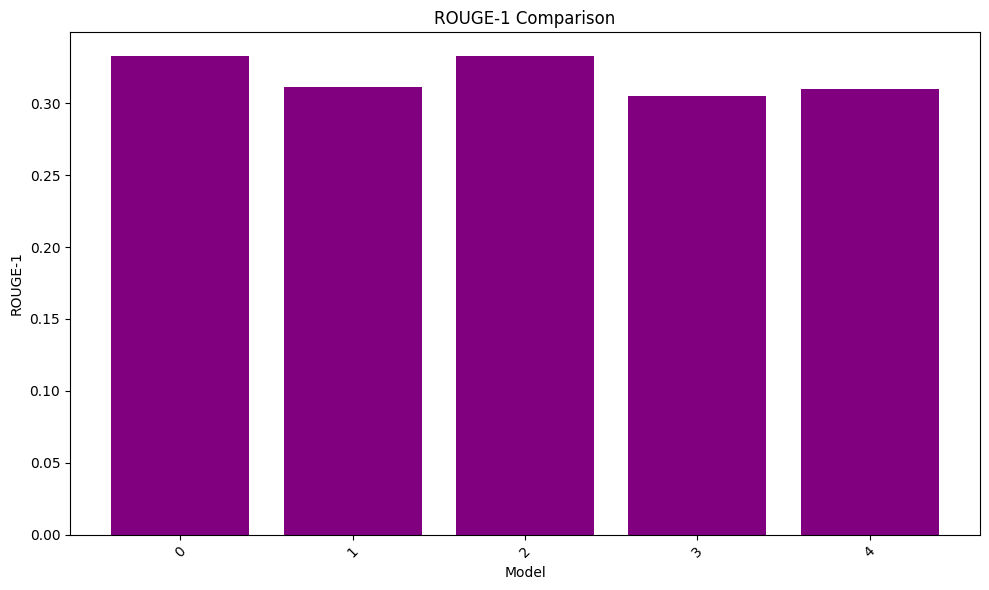

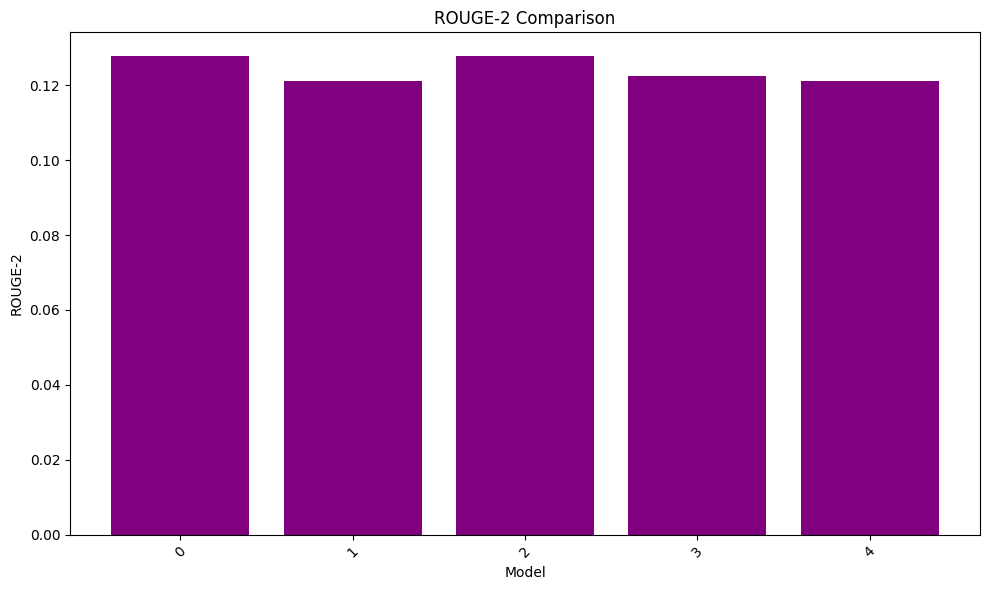

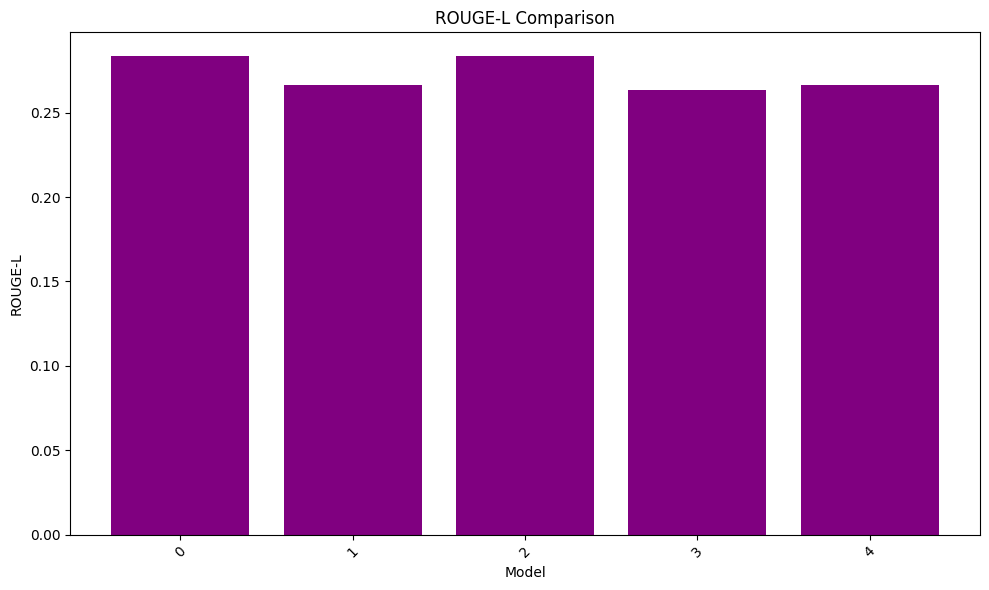

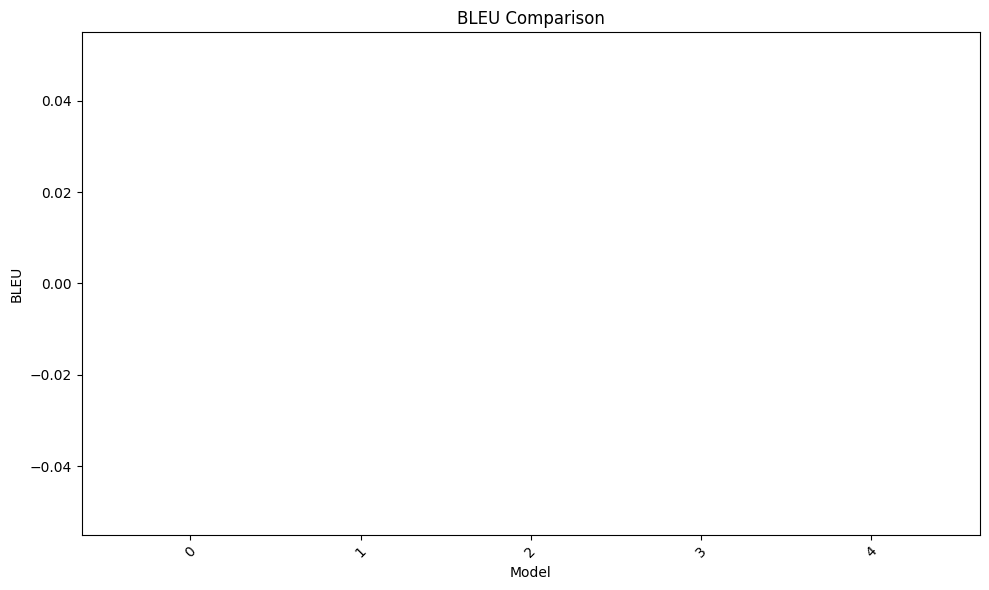

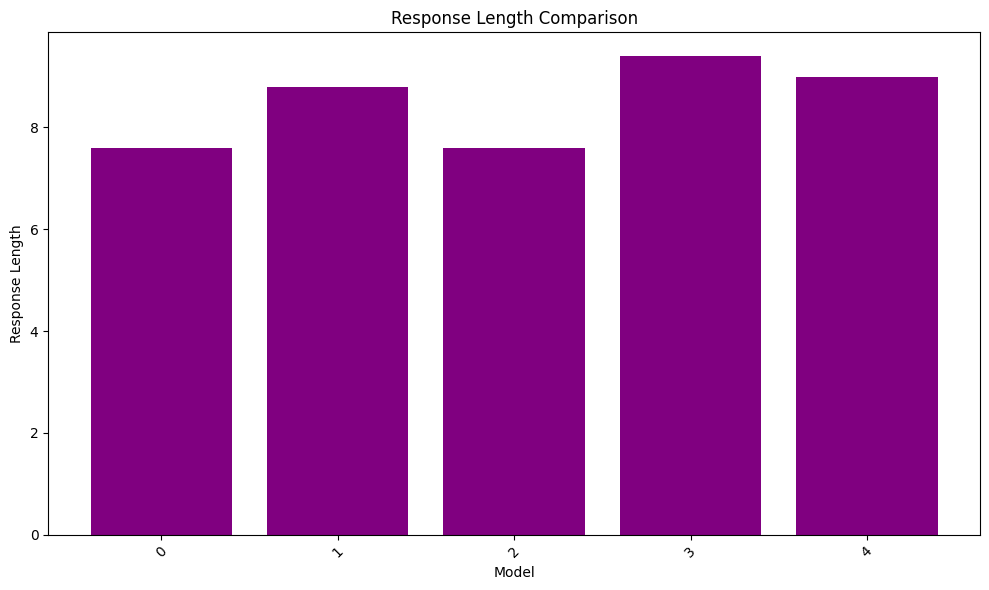

In [299]:
topsis_columns = ['Unnamed: 0', 'BLEU', 'ROUGE-1', 'ROUGE-2', 'ROUGE-L', 'Response Length', 'Topsis Score', 'Rank']

# Create a new DataFrame with the selected columns for TOPSIS results
topsis_csv_data = topsis_results[topsis_columns]

# Save the new TOPSIS results to a CSV file
topsis_csv_data.to_csv('topsis_results.csv', index=False)

print("TOPSIS results saved to topsis_results.csv")

# Plotting TOPSIS Bar Graph
plt.figure(figsize=(10, 5))
plt.barh(result_topsis['Unnamed: 0'], result_topsis['Topsis Score'], color='purple')
plt.xlabel('TOPSIS Score')
plt.ylabel('Model')
plt.title('TOPSIS Ranking of Models')
plt.gca().invert_yaxis() 
plt.tight_layout()
plt.savefig('topsis_BarGraph.png')
plt.show()

print("TOPSIS Bar Graph saved to topsis_BarGraph.png")

# Calculate BLEU score
bleu_score = calculate_bleu([response], [generated_response])

# Plotting function for each metric
metrics = ['ROUGE-1', 'ROUGE-2', 'ROUGE-L','BLEU']

for metric in metrics:
    plt.figure(figsize=(10, 6))
    plt.bar(data.index, data[metric], color='purple')
    plt.xlabel('Model')
    plt.ylabel(metric)
    plt.title(f'{metric} Comparison')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig(f'{metric}_comparison.png')
    plt.show()

# Plotting response length
plt.figure(figsize=(10, 6))
plt.bar(data.index, data['Response Length'], color='purple')
plt.xlabel('Model')
plt.ylabel('Response Length')
plt.title('Response Length Comparison')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('response_length_comparison.png')
plt.show()